<a href="https://colab.research.google.com/github/noraboucetta/mimic_project/blob/main/mimic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers torchvision rarfile --quiet



In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import AutoTokenizer, AutoModel
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


In [ ]:
# ===== 0. Device et hyperparamètres =====
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
MAX_LEN = 128
LR = 1e-4
EPOCHS = 70
PATIENCE = 10


In [ ]:
# ===== 1. Décompresser le fichier zip =====
zip_path = "/content/archive5.rar"  # mettre le chemin correct
output_dir = "/content/mimic-cxr-dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

TEXT_ROOT = os.path.join(output_dir, "mimic-cxr-dataset/mimic-cxr-reports/files")
IMAGE_ROOT = os.path.join(output_dir, "mimic-cxr-dataset/official_data_iccv_final/files")


In [ ]:
# ===== 2. Pathologies filtrées =====
PATHOLOGIES_FILTERED = [
    "No Finding",
    "Cardiomegaly",
    "Lung Lesion",
    "Pleural Effusion",
    "Support Devices"
]

def extract_labels_from_report_filtered(report):
    report = report.lower()
    labels = {p: 0 for p in PATHOLOGIES_FILTERED}

    if "no finding" in report or "no acute cardiopulmonary" in report or "normal" in report:
        labels["No Finding"] = 1
    if "cardiomegaly" in report or "enlarged heart" in report:
        labels["Cardiomegaly"] = 1
    if "lesion" in report or "nodule" in report or "mass" in report:
        labels["Lung Lesion"] = 1
    if "pleural effusion" in report or "effusion" in report:
        labels["Pleural Effusion"] = 1
    if "tube" in report or "catheter" in report or "line" in report or "pacemaker" in report:
        labels["Support Devices"] = 1
       # gestion simple des négations
    negations = ["no ", "without ", "free of "]
    for key in labels:
        for neg in negations:
            if neg + key.lower() in report:
                labels[key] = 0

    return torch.tensor(list(labels.values()), dtype=torch.float)


In [ ]:
# ===== 3. Dataset multimodal =====
class MimicDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ])
        self.tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        txt_path, img_paths = self.samples[idx]
        with open(txt_path,'r') as f:
            report = f.read()

        labels = extract_labels_from_report_filtered(report)

        encoding = self.tokenizer(report, truncation=True, padding='max_length',
                                  max_length=MAX_LEN, return_tensors='pt')

        imgs = []
        for p in img_paths:
            img = Image.open(p).convert('RGB')
            imgs.append(self.transform(img))
        if len(imgs) == 0:
            imgs = [torch.zeros(3,224,224)]
        imgs = torch.stack(imgs).mean(dim=0)

        return imgs, encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0), labels



In [ ]:
# ===== 4. Construction des samples =====
def build_samples(text_root, image_root):
    samples = []
    for p in os.listdir(text_root):
        p_path = os.path.join(text_root, p)
        if not os.path.isdir(p_path): continue
        for subj in os.listdir(p_path):
            subj_path = os.path.join(p_path, subj)
            if not os.path.isdir(subj_path): continue
            txt_files = [f for f in os.listdir(subj_path) if f.endswith('.txt')]
            for txt_file in txt_files:
                txt_path = os.path.join(subj_path, txt_file)
                study_name = os.path.splitext(txt_file)[0]
                img_path = os.path.join(image_root, p, subj, study_name)
                if not os.path.exists(img_path): continue
                imgs = [os.path.join(img_path,i) for i in os.listdir(img_path) if i.endswith('.jpg')]
                if len(imgs)==0: continue
                samples.append((txt_path, imgs))
    return samples

all_samples = build_samples(TEXT_ROOT, IMAGE_ROOT)
train_samples, temp_samples = train_test_split(all_samples, test_size=0.3, random_state=42)
val_samples, test_samples = train_test_split(temp_samples, test_size=0.5, random_state=42)

train_dl = DataLoader(MimicDataset(train_samples), batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(MimicDataset(val_samples), batch_size=BATCH_SIZE)
test_dl = DataLoader(MimicDataset(test_samples), batch_size=BATCH_SIZE)

print(f"Train: {len(train_dl.dataset)} | Val: {len(val_dl.dataset)} | Test: {len(test_dl.dataset)}")



Train: 10922 | Val: 2341 | Test: 2341


In [ ]:
# ===== 5. Modèle =====
class ImageEncoder(nn.Module):
    def __init__(self, out_dim=256):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(base.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(nn.Linear(512,out_dim), nn.ReLU(), nn.Dropout(0.3))

    def forward(self,x):
        f = self.features(x)
        f = self.pool(f).flatten(1)
        return self.fc(f)

class TextEncoder(nn.Module):
    def __init__(self, out_dim=256):
        super().__init__()
        self.bert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        for p in self.bert.parameters():
            p.requires_grad = False
        self.attn = nn.Linear(768,1)
        self.fc = nn.Sequential(nn.Linear(768,out_dim), nn.ReLU(), nn.Dropout(0.3))

    def forward(self, ids, mask):
        out = self.bert(input_ids=ids, attention_mask=mask).last_hidden_state
        w = torch.softmax(self.attn(out), dim=1)
        emb = (w*out).sum(dim=1)
        return self.fc(emb)

class MultimodalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.img_enc = ImageEncoder()
        self.txt_enc = TextEncoder()
        self.cross_attn = nn.MultiheadAttention(256, 8, batch_first=True)
        # ⚡ Sortie = 5 pathologies filtrées
        self.classifier = nn.Linear(256, len(PATHOLOGIES_FILTERED))

    def forward(self,img,ids,mask):
        img_f = self.img_enc(img).unsqueeze(1)
        txt_f = self.txt_enc(ids,mask).unsqueeze(1)
        fused,_ = self.cross_attn(txt_f,img_f,img_f)
        return self.classifier(fused.squeeze(1))



In [ ]:
# ===== 1. Définir la fonction pour calculer pos_weight =====
def compute_pos_weight(train_dl):
    all_labels = []
    for _, _, _, labels in train_dl:
        all_labels.append(labels)
    labels_tensor = torch.cat(all_labels, dim=0)
    pos_counts = labels_tensor.sum(0)
    neg_counts = labels_tensor.shape[0] - pos_counts
    pos_weight = neg_counts / (pos_counts + 1e-5)  # epsilon pour éviter div0
    return pos_weight.to(DEVICE)

In [ ]:
# ===== 2. Training complet =====
def train_model_weighted(train_dl, val_dl, model_class, pathologies, lr=LR, epochs=EPOCHS, patience=PATIENCE):
    model = model_class().to(DEVICE)

    # Pos_weight pour BCEWithLogitsLoss
    pos_weight = compute_pos_weight(train_dl)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scaler = torch.cuda.amp.GradScaler()

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for img, ids, mask, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}"):
            img, ids, mask, labels = img.to(DEVICE), ids.to(DEVICE), mask.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(img, ids, mask)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dl)

        # ===== Validation =====
        model.eval()
        val_loss = 0
        val_preds_list, val_labels_list = [], []
        with torch.no_grad():
            for img, ids, mask, labels in val_dl:
                img, ids, mask, labels = img.to(DEVICE), ids.to(DEVICE), mask.to(DEVICE), labels.to(DEVICE)
                outputs = model(img, ids, mask)
                val_loss += criterion(outputs, labels).item()
                val_preds_list.append(torch.sigmoid(outputs).cpu())
                val_labels_list.append(labels.cpu())

        avg_val_loss = val_loss / len(val_dl)

        # ===== Early stopping =====
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
            print(f"✅ Epoch {epoch+1}: Best model saved")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"🛑 Early stopping at epoch {epoch+1}")
                break


        # ===== Calcul F1 micro et macro =====
        val_preds = torch.cat(val_preds_list, dim=0)
        val_labels = torch.cat(val_labels_list, dim=0)
        val_preds_binary = (val_preds >= 0.5).int()
        f1_micro = f1_score(val_labels, val_preds_binary, average='micro', zero_division=0)
        f1_macro = f1_score(val_labels, val_preds_binary, average='macro', zero_division=0)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1-micro: {f1_micro:.4f} | F1-macro: {f1_macro:.4f}")

    model.load_state_dict(torch.load("best_model.pt"))

    return model

In [ ]:
# ===== 7. Lancer l'entraînement =====
model = train_model_weighted(train_dl, val_dl, MultimodalModel, PATHOLOGIES_FILTERED)
print("✅ Entraînement terminé, meilleur modèle sauvegardé dans 'best_model.pt'")




/tmp/ipython-input-2953566957.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1:   0%|          | 0/1366 [00:00<?, ?it/s]/tmp/ipython-input-2953566957.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1: 100%|██████████| 1366/1366 [02:58<00:00,  7.64it/s]


✅ Epoch 1: Best model saved
Epoch 1/70 | Train Loss: 0.8239 | Val Loss: 0.8202 | F1-micro: 0.5315 | F1-macro: 0.5074


Epoch 2:   0%|          | 0/1366 [00:00<?, ?it/s]/tmp/ipython-input-2953566957.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2: 100%|██████████| 1366/1366 [02:53<00:00,  7.85it/s]


✅ Epoch 2: Best model saved
Epoch 2/70 | Train Loss: 0.7900 | Val Loss: 0.8132 | F1-micro: 0.5603 | F1-macro: 0.5190


Epoch 3:   0%|          | 0/1366 [00:00<?, ?it/s]/tmp/ipython-input-2953566957.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3: 100%|██████████| 1366/1366 [02:55<00:00,  7.79it/s]


✅ Epoch 3: Best model saved
Epoch 3/70 | Train Loss: 0.7558 | Val Loss: 0.7973 | F1-micro: 0.6342 | F1-macro: 0.5501


Epoch 4:   0%|          | 0/1366 [00:00<?, ?it/s]/tmp/ipython-input-2953566957.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4: 100%|██████████| 1366/1366 [02:53<00:00,  7.88it/s]


Epoch 4/70 | Train Loss: 0.7066 | Val Loss: 0.8372 | F1-micro: 0.5891 | F1-macro: 0.5332


Epoch 5:   0%|          | 0/1366 [00:00<?, ?it/s]/tmp/ipython-input-2953566957.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5: 100%|██████████| 1366/1366 [02:53<00:00,  7.88it/s]


Epoch 5/70 | Train Loss: 0.6387 | Val Loss: 0.8793 | F1-micro: 0.5932 | F1-macro: 0.5279


Epoch 6:   0%|          | 0/1366 [00:00<?, ?it/s]/tmp/ipython-input-2953566957.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6: 100%|██████████| 1366/1366 [02:51<00:00,  7.98it/s]


Epoch 6/70 | Train Loss: 0.5558 | Val Loss: 1.0821 | F1-micro: 0.5752 | F1-macro: 0.5013


Epoch 7:   0%|          | 0/1366 [00:00<?, ?it/s]/tmp/ipython-input-2953566957.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7: 100%|██████████| 1366/1366 [02:52<00:00,  7.90it/s]


Epoch 7/70 | Train Loss: 0.4934 | Val Loss: 1.1798 | F1-micro: 0.6160 | F1-macro: 0.5184


Epoch 8:   0%|          | 0/1366 [00:00<?, ?it/s]/tmp/ipython-input-2953566957.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8: 100%|██████████| 1366/1366 [02:53<00:00,  7.86it/s]


Epoch 8/70 | Train Loss: 0.4523 | Val Loss: 1.2048 | F1-micro: 0.6136 | F1-macro: 0.5192


Epoch 9:   0%|          | 0/1366 [00:00<?, ?it/s]/tmp/ipython-input-2953566957.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9: 100%|██████████| 1366/1366 [02:51<00:00,  7.97it/s]


Epoch 9/70 | Train Loss: 0.4130 | Val Loss: 1.3128 | F1-micro: 0.6169 | F1-macro: 0.5201


Epoch 10:   0%|          | 0/1366 [00:00<?, ?it/s]/tmp/ipython-input-2953566957.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10: 100%|██████████| 1366/1366 [02:56<00:00,  7.72it/s]


Epoch 10/70 | Train Loss: 0.3764 | Val Loss: 1.4474 | F1-micro: 0.6041 | F1-macro: 0.5115


Epoch 11:   0%|          | 0/1366 [00:00<?, ?it/s]/tmp/ipython-input-2953566957.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11: 100%|██████████| 1366/1366 [02:55<00:00,  7.78it/s]


Epoch 11/70 | Train Loss: 0.3473 | Val Loss: 1.6391 | F1-micro: 0.6162 | F1-macro: 0.5135


Epoch 12:   0%|          | 0/1366 [00:00<?, ?it/s]/tmp/ipython-input-2953566957.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12: 100%|██████████| 1366/1366 [02:53<00:00,  7.88it/s]


Epoch 12/70 | Train Loss: 0.3351 | Val Loss: 1.4061 | F1-micro: 0.6277 | F1-macro: 0.5227


Epoch 13:   0%|          | 0/1366 [00:00<?, ?it/s]/tmp/ipython-input-2953566957.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13: 100%|██████████| 1366/1366 [02:51<00:00,  7.97it/s]


🛑 Early stopping at epoch 13
✅ Entraînement terminé, meilleur modèle sauvegardé dans 'best_model.pt'


In [ ]:
# ===== 8. Fonction plot F1 =====
def plot_f1_per_class(f1_scores, positives, class_names=None):
    idx = np.arange(len(f1_scores))
    plt.figure(figsize=(10,5))
    plt.bar(idx, f1_scores)
    plt.xlabel("Classes (maladies)")
    plt.ylabel("F1-score")
    plt.title("F1-score par pathologie")
    if class_names:
        plt.xticks(idx, class_names, rotation=45)
    else:
        plt.xticks(idx, idx)
    for i, p in enumerate(positives):
        plt.text(i, f1_scores[i]+0.01, int(p), ha='center', fontsize=8)
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report

def evaluate_model(model, test_dl, threshold=0.5):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for img, ids, mask, labels in test_dl:
            img = img.to(DEVICE)
            ids = ids.to(DEVICE)
            mask = mask.to(DEVICE)

            outputs = model(img, ids, mask)
            probs = torch.sigmoid(outputs)

            all_preds.append(probs.cpu())
            all_labels.append(labels.cpu())

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()

    # Binarisation
    y_pred_bin = (y_pred >= threshold).astype(int)

    # ===== Métriques =====
    acc = (y_pred_bin == y_true).mean()
    f1_micro = f1_score(y_true, y_pred_bin, average="micro", zero_division=0)
    f1_macro = f1_score(y_true, y_pred_bin, average="macro", zero_division=0)
    f1_per_class = f1_score(y_true, y_pred_bin, average=None, zero_division=0)

    print("===== ÉVALUATION TEST =====")
    print(f"Accuracy globale       : {acc:.4f}")
    print(f"F1-score micro         : {f1_micro:.4f}")
    print(f"F1-score macro         : {f1_macro:.4f}")

    # Nombre de vrais labels par classe
    positives_per_class = y_true.sum(axis=0)

    return {
        "accuracy": acc,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "f1_per_class": f1_per_class,
        "positives_per_class": positives_per_class
    }


In [ ]:
metrics = evaluate_model(model, test_dl)


===== ÉVALUATION TEST =====
Accuracy globale       : 0.6896
F1-score micro         : 0.6263
F1-score macro         : 0.5477


In [ ]:
def plot_f1_per_class(f1_scores, positives, class_names=None):
    idx = np.arange(len(f1_scores))

    plt.figure(figsize=(14, 5))
    plt.bar(idx, f1_scores)
    plt.xlabel("Classes (maladies)")
    plt.ylabel("F1-score")
    plt.title("F1-score par maladie")
    plt.savefig("/content/drive/MyDrive/MonProjet/F1-score par maladie.png")
    if class_names:
        plt.xticks(idx, class_names, rotation=90)
    else:
        plt.xticks(idx, idx)

    for i, p in enumerate(positives):
        plt.text(i, f1_scores[i] + 0.01, int(p), ha='center', fontsize=8)

    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


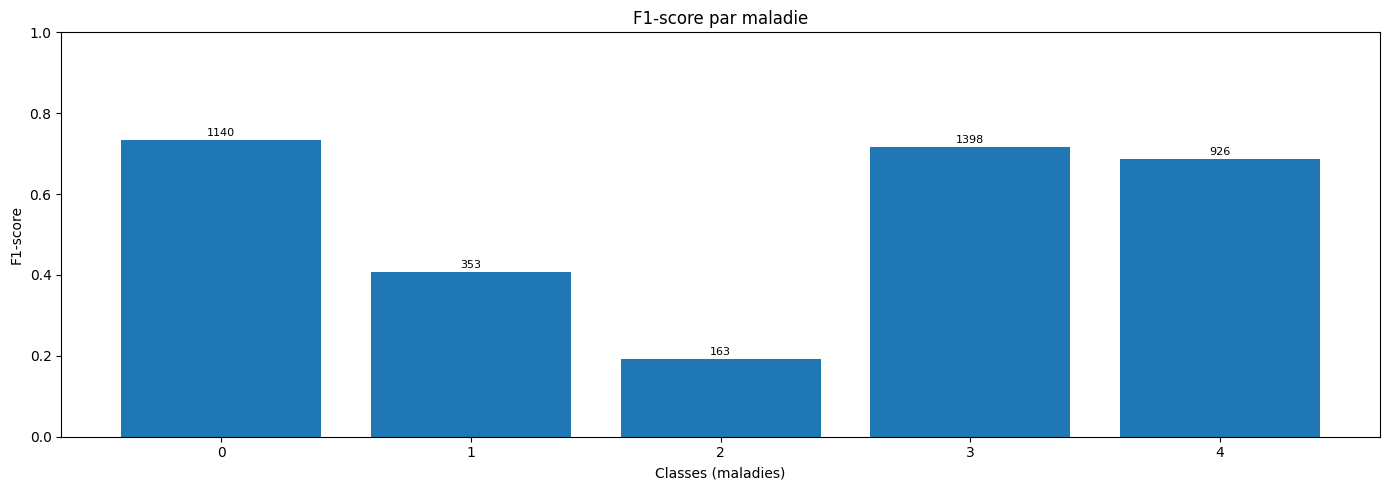

In [ ]:
plot_f1_per_class(
    metrics["f1_per_class"],
    metrics["positives_per_class"]
)

# Sauvegarder sur Drive



In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

def compute_auroc_per_class(model, dataloader):
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for img, ids, mask, labels in dataloader:
            img = img.to(DEVICE)
            ids = ids.to(DEVICE)
            mask = mask.to(DEVICE)

            outputs = model(img, ids, mask)
            probs = torch.sigmoid(outputs)

            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    y_probs = torch.cat(all_probs).numpy()
    y_true = torch.cat(all_labels).numpy()

    aurocs = []
    valid_classes = []

    for c in range(y_true.shape[1]):
        # ignorer classes avec 0 ou 1 label unique
        if len(np.unique(y_true[:, c])) < 2:
            aurocs.append(np.nan)
        else:
            auc = roc_auc_score(y_true[:, c], y_probs[:, c])
            aurocs.append(auc)
            valid_classes.append(c)

    return np.array(aurocs), y_true.sum(axis=0)


In [87]:
aurocs, positives_per_class = compute_auroc_per_class(model, test_dl)

print("AUROC par classe:")
for i, auc in enumerate(aurocs):
    print(f"Classe {i}: {auc}")


AUROC par classe:
Classe 0: 0.8193552156828374
Classe 1: 0.7702831721205419
Classe 2: 0.660393674615649
Classe 3: 0.6002576017549688
Classe 4: 0.8046546947622282


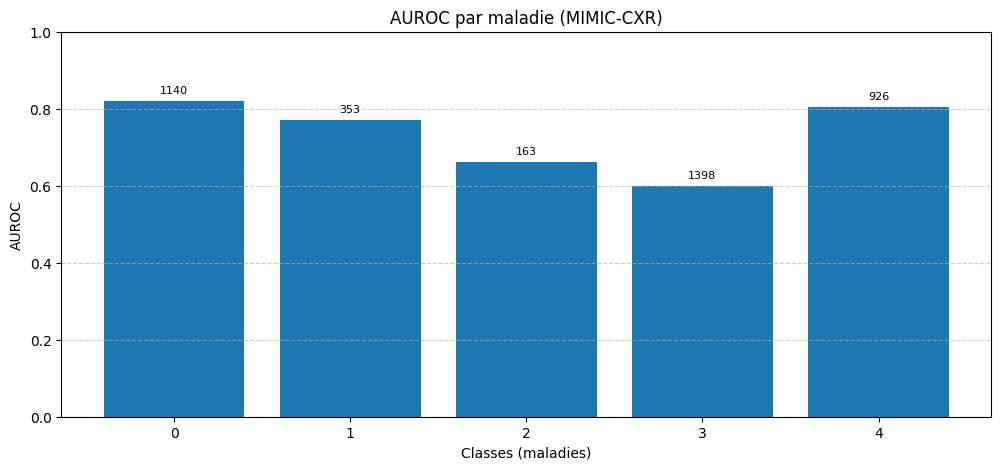

In [ ]:
plt.figure(figsize=(12,5))

valid_idx = ~np.isnan(aurocs)

plt.bar(
    np.where(valid_idx)[0],
    aurocs[valid_idx]
)

plt.ylim(0,1)
plt.xlabel("Classes (maladies)")
plt.ylabel("AUROC")
plt.title("AUROC par maladie (MIMIC-CXR)")
# Sauvegarder sur Drive
plt.savefig("/content/drive/MyDrive/MonProjet/AUROC par maladie (MIMIC-CXR).png")

plt.grid(axis="y", linestyle="--", alpha=0.6)

# afficher nb de cas
for i in np.where(valid_idx)[0]:
    plt.text(i, aurocs[i] + 0.02, int(positives_per_class[i]),
             ha='center', fontsize=8)

plt.show()




In [ ]:
import torch

def predict_patient(model, img, ids, mask, threshold=0.5):
    model.eval()

    with torch.no_grad():
        img = img.unsqueeze(0).to(DEVICE)     # [1, 3, 224, 224]
        ids = ids.unsqueeze(0).to(DEVICE)     # [1, seq_len]
        mask = mask.unsqueeze(0).to(DEVICE)

        logits = model(img, ids, mask)
        probs = torch.sigmoid(logits).cpu().squeeze(0)

    preds = (probs >= threshold).int()

    return probs, preds


In [ ]:
img, ids, mask, label = test_dl.dataset[0]

probs, preds = predict_patient(model, img, ids, mask)

print("Probabilités par classe:")
print(probs)

print("\nMaladies prédites (1 = présente):")
print(preds)

print("\nVraies maladies:")
print(label)


Probabilités par classe:
tensor([0.1155, 0.6667, 0.3090, 0.6654, 0.8608])

Maladies prédites (1 = présente):
tensor([0, 1, 0, 1, 1], dtype=torch.int32)

Vraies maladies:
tensor([0., 1., 0., 1., 0.])


In [ ]:
# Nombre d'exemples à tester
N = 5

# Liste des pathologies (pour ton modèle filtré à 5 classes)
pathologies = [
    "No Finding", "Cardiomegaly", "Lung Lesion",
    "Pleural Effusion", "Support Devices"
]

for idx in range(N):
    img, ids, mask, label = test_dl.dataset[idx]

    probs, preds = predict_patient(model, img, ids, mask, threshold=0.5)

    print(f"\n===== Exemple {idx+1} =====")

    print("\nDétail par pathologie :")
    for i, name in enumerate(pathologies):
        print(f"{name:20s} | Proba: {probs[i]:.3f} | Prédit: {preds[i].item()} | Vérité: {int(label[i].item())}")



===== Exemple 1 =====

Détail par pathologie :
No Finding           | Proba: 0.115 | Prédit: 0 | Vérité: 0
Cardiomegaly         | Proba: 0.667 | Prédit: 1 | Vérité: 1
Lung Lesion          | Proba: 0.309 | Prédit: 0 | Vérité: 0
Pleural Effusion     | Proba: 0.665 | Prédit: 1 | Vérité: 1
Support Devices      | Proba: 0.861 | Prédit: 1 | Vérité: 0

===== Exemple 2 =====

Détail par pathologie :
No Finding           | Proba: 0.881 | Prédit: 1 | Vérité: 1
Cardiomegaly         | Proba: 0.184 | Prédit: 0 | Vérité: 0
Lung Lesion          | Proba: 0.313 | Prédit: 0 | Vérité: 0
Pleural Effusion     | Proba: 0.563 | Prédit: 1 | Vérité: 1
Support Devices      | Proba: 0.101 | Prédit: 0 | Vérité: 0

===== Exemple 3 =====

Détail par pathologie :
No Finding           | Proba: 0.245 | Prédit: 0 | Vérité: 0
Cardiomegaly         | Proba: 0.641 | Prédit: 1 | Vérité: 1
Lung Lesion          | Proba: 0.207 | Prédit: 0 | Vérité: 0
Pleural Effusion     | Proba: 0.498 | Prédit: 0 | Vérité: 0
Support Devices 

In [ ]:
import torch

# Sauvegarder le modèle
torch.save(model.state_dict(), "/content/drive/MyDrive/MonProjet/model.pth")

# Pour le recharger plus tard
model.load_state_dict(torch.load("/content/drive/MyDrive/MonProjet/model.pth"))



<All keys matched successfully>

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/MonProjet/best_model.pt")